### Important
Run SLiM model with neutral mutations and compare the final SFS of that model with results from the deleterious variation simulations.

Does linkage to deleterious mutations affect the SFS? It should not produce any shifts - but perhaps it increases the variance?

How does neutral linkage simulation compare to neutral diffusion?

* constant Ne of different values
* Kimura's exact solution (starting from a fixed value of the allele frequency)

In [1]:
suppressPackageStartupMessages(library(tidyverse))

suppressPackageStartupMessages(source("../R/process_slim_output.R"))

Conflicts with tidy packages ---------------------------------------------------


In [2]:
traject_dir <- "../simulations/different_models"

In [3]:
library(parallel)

(gens <- c(1:10,25,50, seq(100, 2200, 300)))  # generations at which we dumped SLiM mutations
(models <- c("constant", "linear", "gravel")) # demographic models simulated
(dominances <- c("0.0", "0.1", "0.5"))        # dominance coefficients simulated

combinations <- expand.grid(gen=gens, model=models, h=dominances)

[1]    1    2    3    4    5    6    7    8    9   10   25   50  100  400  700
[16] 1000 1300 1600 1900 2200

[1] "constant" "linear"   "gravel"

[1] "0.0" "0.1" "0.5"

In [4]:
if (!file.exists("../tmp/neutral_mutations.Rds")) {

mutations_df_list <-
    mclapply(
        1 : nrow(combinations),
        function(i) {
            model <- combinations[i, "model"]
            gen <- as.integer(combinations[i, "gen"])
            h <- combinations[i, "h"]

            # load the whole SLiM output file first
            slim_file <- read_slim_file(file.path(traject_dir,
                                                  paste0(model,
                                                         "__h_", h,
                                                         "__init_nea_0.1__rep_1__dump_gen_",
                                                         gen,
                                                         ".txt")))

            # get the Ne of modern humans in this generation
            N <- filter(read_populations(slim_file), pop_id == "p3")$pop_size

            neutral_exonic <-
                read_mutations(slim_file, "m1", "p2") %>%
                mutate(model=model, kind="exonic", gen=gen, freq=freq / (2 * N))

            neutral_nonexonic <-
                read_mutations(slim_file, "m2", "p2") %>%
                mutate(model=model, kind="nonexonic", gen=gen, freq=freq / (2 * N))

            bind_rows(neutral_exonic, neutral_nonexonic) %>% mutate(h=h)
        },
        mc.cores=40 #detectCores()
    )
    
    mutations <- bind_rows(mutations_df_list) %>% mutate(gen=factor(gen))
    saveRDS(mutations, "../tmp/neutral_mutations.Rds")
    
} else {
    
mutations <- readRDS("../tmp/neutral_mutations.Rds")

}

mutations %<>% filter(kind == "nonexonic")

In [5]:
options(repr.plot.width=15, repr.plot.height=10)

In [6]:
sfs <-
    suppressMessages(
        read_tsv("../input_data/all_tag_snps.EUR.merged.ALL.0.3_R2_cluster.1KG_phase3_essentials.median_af.bed.extended_LD",
             col_names=c("chr", "start", "stop", "AFA", "AFR",
                         "AMR", "EAS", "EUR", "PNG", "SAS",
                         "total_snps", "total_length"))
    ) %>%
    mutate(bin=findInterval(total_length, vec=c(0, 30000, 200000))) %>%
    filter(bin == 2) %>%
    select(AMR, EAS, EUR, SAS) %>%
    gather(pop, freq)

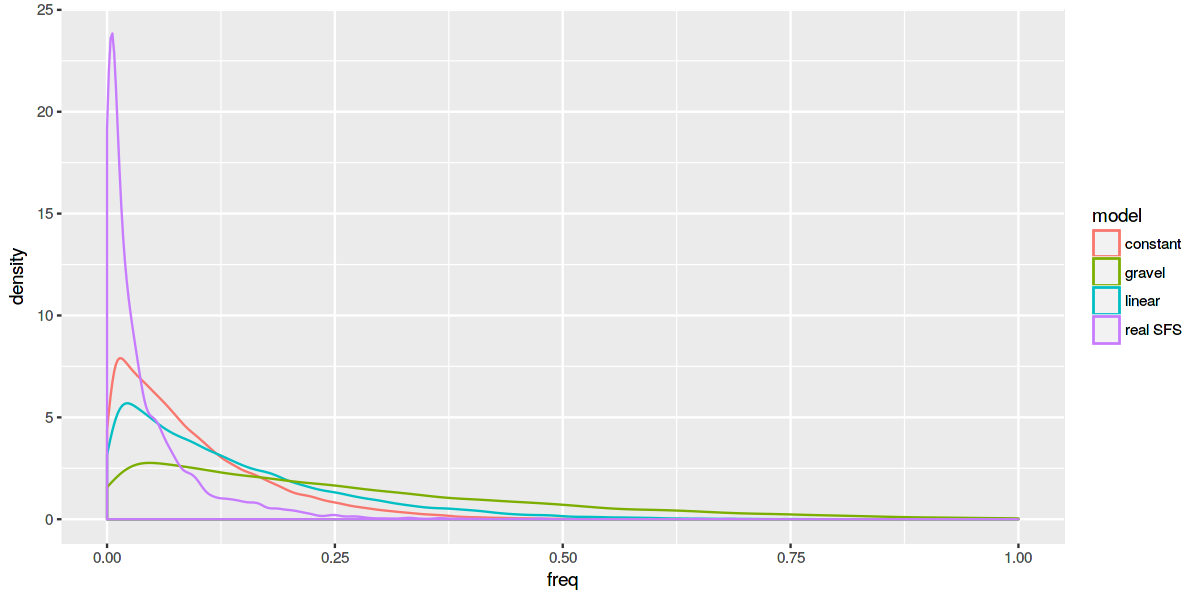

In [14]:
options(repr.plot.width=10, repr.plot.height=5)

ggplot() +
    geom_density(aes(freq, group=model, color=model), data=filter(mutations, gen == 2200, kind == "nonexonic")) +
    geom_density(aes(freq, color=model, group=pop), data=mutate(filter(sfs, pop == "EUR"), model="real SFS"))

In [83]:
filter(mutations, gen == 2200) %>% group_by(model, kind) %>% summarize(mean(freq))

model,kind,mean(freq)
constant,exonic,0.09691197
constant,nonexonic,0.09478634
linear,exonic,0.13710290
linear,nonexonic,0.13407396
gravel,exonic,0.26104487
gravel,nonexonic,0.25309186


In [11]:
filter(mutations, model == "constant") %>%
    group_by(gen, kind) %>%
    summarise(freq=sum(freq) / 10000) %>% tail

gen,kind,freq
1600,exonic,0.03187242
1600,nonexonic,0.12673048
1900,exonic,0.03131397
1900,nonexonic,0.12594894
2200,exonic,0.03077587
2200,nonexonic,0.12665424


In [27]:
group_by(mutations, model, gen, kind, h) %>%
    summarise(freq=mean(freq)) %>% tail

model,gen,kind,h,freq
gravel,1600,exonic,0.5,0.2474155
gravel,1600,nonexonic,0.5,0.2389812
gravel,1900,exonic,0.5,0.2579083
gravel,1900,nonexonic,0.5,0.2493023
gravel,2200,exonic,0.5,0.2610449
gravel,2200,nonexonic,0.5,0.2530919


In [10]:
options(repr.plot.width=15, repr.plot.height=5)

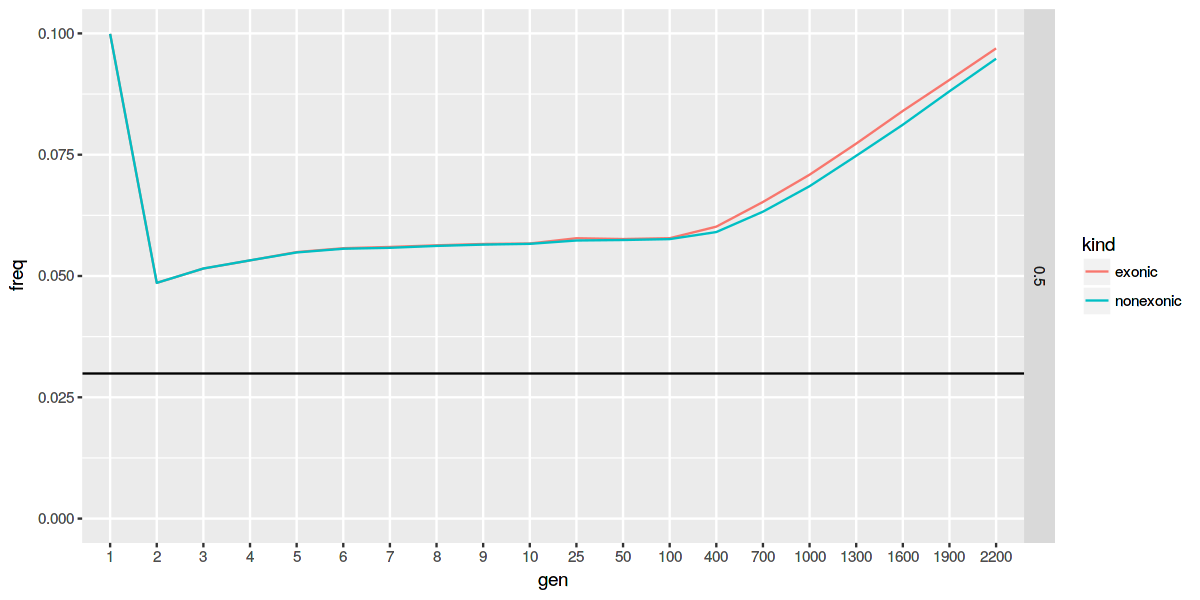

In [87]:
filter(mutations, model == "constant") %>%
    group_by(gen, kind, h) %>%
    summarise(freq=mean(freq)) %>%
    ggplot(aes(gen, freq, group=kind, color=kind)) + geom_line() + ylim(0, 0.1) +
    facet_grid(h ~ .) + geom_hline(yintercept = 0.03)

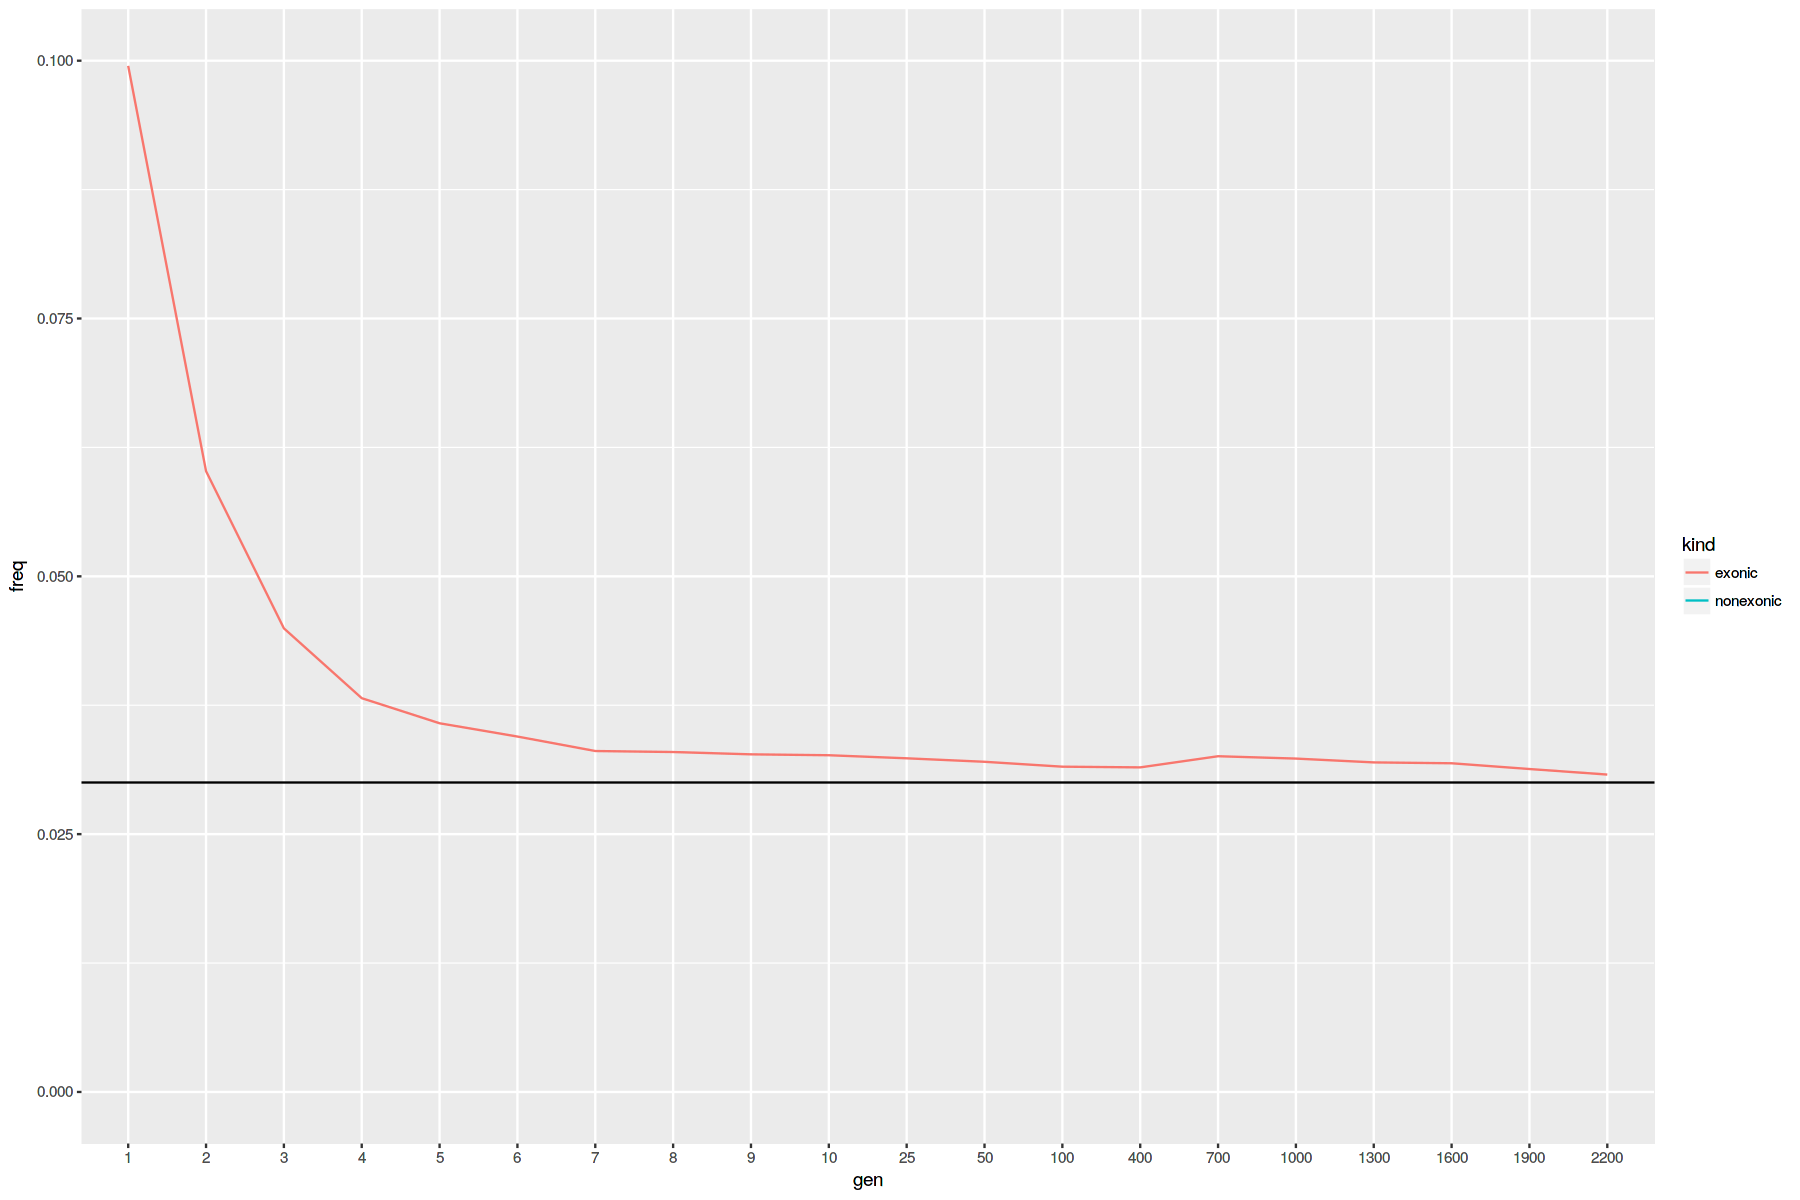

In [37]:
filter(mutations, model == "gravel") %>%
    group_by(gen, kind) %>%
    summarise(freq=sum(freq)/10000) %>%
    ggplot(aes(gen, freq, group=kind, color=kind)) + geom_line() + ylim(0, 0.1) + geom_hline(yintercept = 0.03)